# Latent Parc

In [1]:
# import required library
import os
os.chdir("..")
from parc import model

from skimage.measure import block_reduce
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, regularizers

import tensorflow as tf

from keras import backend as K

### Data Preparation

In [2]:
img_width = 448
img_height = 896
ts = 20
fields = 3

In [ ]:
total = np.empty((0,img_width,img_height,ts*fields))
filepath = "parc/Single_void_sim_data"
for filename in os.listdir(filepath):
    print(filename)
    caseidx = np.load(os.path.join(os.getcwd(), filepath, filename))
    print(caseidx.shape)
    if (caseidx.shape[2] > ts*fields) and (caseidx.shape[1] > img_height) and (caseidx.shape[0] > img_width):
        caseidx = caseidx[:img_width,:img_height,:ts*fields]
        caseidx = np.expand_dims(caseidx,0)
        total = np.concatenate((total,caseidx),0)
total = np.array(total)
total = block_reduce(total, block_size=(1, 2, 2, 1), func=np.max)
np.save("singleVoidData", total)
print(total.shape)

In [ ]:
total = np.load("parc/singleVoidData.npy")
total = total.reshape(total.shape[0], total.shape[1], total.shape[2], ts, fields)

#### Normalize Data

In [ ]:
for channel in range(fields):
    norm_max = np.amax(total[:, :, :, :, channel])
    norm_min = np.amin(total[:, :, :, :, channel])
    total[:, :, :, :, channel] = (total[:, :, :, :, channel] - norm_min) / (
      norm_max - norm_min
    )
    total[:, :, :, :, channel] = (total[:, :, :, :, channel] * 2.0) - 1.0

# Learning microstructure latent representation

### Microstructure data initialization

In [ ]:
micro_data = np.squeeze(total[:,:,:,:,2])
micro_data_train = micro_data[:80]
micro_in = []
micro_out = []
for i in range(micro_data_train.shape[0]):
    for j in range (micro_data_train.shape[3]-1):
        micro_in.append(micro_data_train[i,:,:,j:j+1])
        micro_out.append(micro_data_train[i,:,:,j+1:j+2])
micro_in = np.array(micro_in)
micro_out = np.array(micro_out)
print(micro_in.shape)
print(micro_out.shape)

### Training model

In [4]:
model_micro = model.PILE()
model_micro.compile(optimizer = tf.keras.optimizers.Adam(lr=0.00001,beta_1=0.9,beta_2=0.99))
model_micro.fit(micro_in, micro_out, batch_size = 4, epochs = 70, shuffle = True)
model_micro.encoder.save_weights('micro_enc_test.h5')
model_micro.decoder.save_weights('micro_dec_test.h5')

NameError: name 'Conv2D' is not defined

### Test

In [ ]:
model_micro = PILE()
model_micro.compile(optimizer = tf.keras.optimizers.Adam(lr=0.00001,beta_1=0.9,beta_2=0.99))
model_micro.encoder.load_weights('micro_enc_test.h5')
model_micro.decoder.load_weights('micro_dec_test.h5')

In [ ]:
test = 80
for idx in range(20):
    z4 = model_micro.encoder(micro_data[test:test+1,:,:,idx:idx+1])
    recon_micro = model_micro.decoder(z4) 
    plt.imshow(np.squeeze(recon_micro), cmap = 'gray', vmin = 0, vmax= 1)
    plt.show()
    plt.imshow(np.squeeze(micro_data[test,:,:,idx]), cmap = 'gray', vmin = 0, vmax= 1)
    plt.show()

# Learning temperature latent representation

### Temperature data initialization

In [ ]:
total_train = total[:80]
temp_data_train = total_train[:,:,:,0::3]
data_in = []
data_out = []
for i in range(total_train.shape[0]):
    for j in range (total_train.shape[3]-1):
        data_in.append(total_train[i,:,:,j:j+1,:])
        data_out.append(total_train[i,:,:,j+1:j+2,:])

data_in = np.array(data_in)
data_out = np.array(data_out)
data_in = np.squeeze(data_in)
data_out = np.squeeze(data_out)
print(data_in.shape)
print(data_out.shape)

(1520, 224, 448, 3)
(1520, 224, 448, 3)


### Training model

In [ ]:
model_temp = PILE()
model_temp.compile(optimizer = tf.keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.99))
model_temp.fit(data_in, data_out, batch_size = 4, epochs = 200, shuffle = True)

model_temp.encoder.save_weights('temp_enc_28_56_linear_constraint_v2.h5')
model_temp.decoder.save_weights('temp_dec_28_56_linear_constraint_v2.h5')
model_temp.latent_evolution.save_weights('temp_pile_28_56_linear_constraint_v2.h5')

### Test

In [ ]:
model_temp = PILE()
model_temp.compile(optimizer = tf.keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.99))
model_temp.encoder.load_weights('temp_enc_28_56_linear_constraint_v2.h5')
model_temp.decoder.load_weights('temp_dec_28_56_linear_constraint_v2.h5')
model_temp.latent_evolution.load_weights('temp_pile_28_56_linear_constraint_v2.h5')

In [ ]:
test = 90
channel = 1
for idx in range(20):
    z4 = model_temp.encoder(np.squeeze((total[test:test+1,:,:,idx:idx+1,:]),axis=3))
    recon_micro = model_temp.decoder(z4) 
    plt.imshow(np.squeeze(recon_micro[:,:,:,channel]), cmap = 'jet', vmax = 1, vmin = -1)
    plt.show()
    plt.imshow(np.squeeze(total[test,:,:,idx,channel]), cmap = 'jet', vmax = 1, vmin = -1)
    plt.show()

# Transform data to latent

In [ ]:
temp_mapping = PILE()
temp_mapping.encoder.load_weights('temp_enc_28_56_linear_constraint_v2.h5')
temp_mapping.encoder.trainable = False
temp_mapping.decoder.load_weights('temp_dec_28_56_linear_constraint_v2.h5')
temp_mapping.decoder.trainable = False
temp_mapping.latent_evolution.load_weights('temp_pile_28_56_linear_constraint_v2.h5')
temp_mapping.latent_evolution.trainable = False

In [ ]:
zt = temp_mapping.encoder(np.squeeze(total[:,:,:,0,:]))
latent_data = []
for t_idx in range(ts):
    zt = temp_mapping.encoder(np.squeeze(total[:,:,:,t_idx,:]))
    latent_data.append(zt)
latent_data = np.array(latent_data)
latent_data = np.moveaxis(latent_data,0,-1)
print(latent_data.shape)

(104, 14, 28, 64, 20)


In [ ]:
num_ts = 6
for ts_idx in range(1,num_ts+1):
    data_in = []
    data_out = []
    total_test = []

    for i in range(80):
        for j in range (19-ts_idx):
            data_in.append(latent_data[i,:,:,:,j+1:j+2])
            data_out.append(latent_data[i,:,:,:,j+2:j+2+ts_idx])
            total_test.append(total_train[i,:,:,j+2:j+2+ts_idx])

    data_in = np.array(data_in)
    data_out = np.array(data_out)
    total_test = np.array(total_test)

    parc = LatentPARC(ts = ts_idx)
    if ts_idx > 1:
        parc.latent_physics.load_weights('latent_parc_strong_recurrent_with_dropout_' + str(ts_idx-1) + '.h5')
        parc.compile(optimizer = tf.keras.optimizers.Adam(lr=0.00005,beta_1=0.5,beta_2=0.99))
        parc.fit([data_in],[data_out,total_test], batch_size = 4, epochs = 100, shuffle = True)
        parc.latent_physics.save_weights('latent_parc_strong_recurrent_with_dropout_' + str(ts_idx) + '.h5')
    else:
        parc.compile(optimizer = tf.keras.optimizers.Adam(lr=0.00005,beta_1=0.5,beta_2=0.99))
        parc.fit([data_in],[data_out,total_test], batch_size = 4, epochs = 100, shuffle = True)
        parc.latent_physics.save_weights('latent_parc_strong_recurrent_with_dropout_' + str(ts_idx) + '.h5')

### Test

(24, 14, 28, 64, 1)
(24, 14, 28, 64, 17)
(24, 224, 448, 17, 3)
ts  0


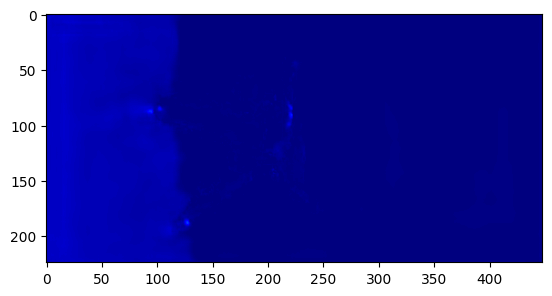

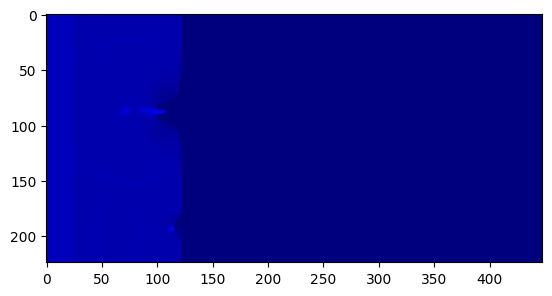

ts  1


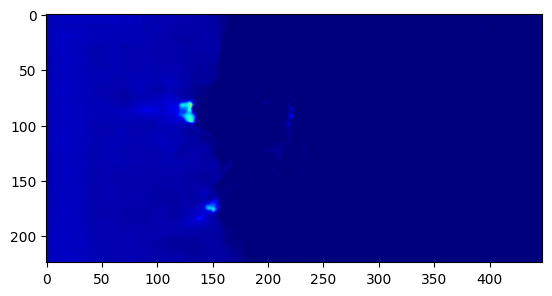

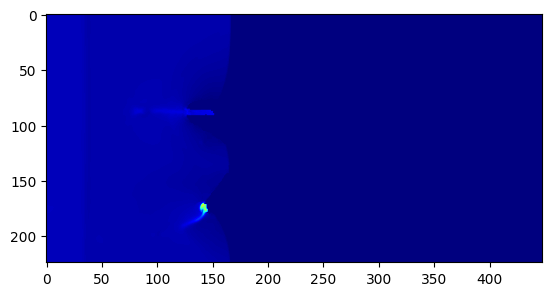

ts  2


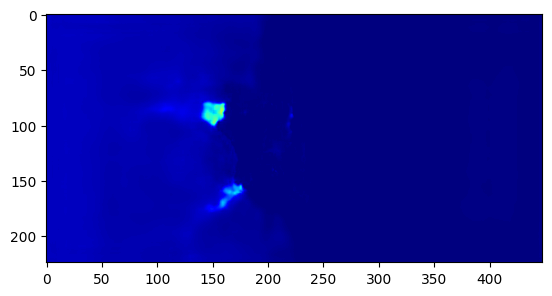

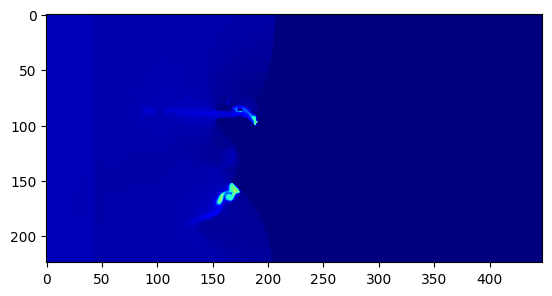

ts  3


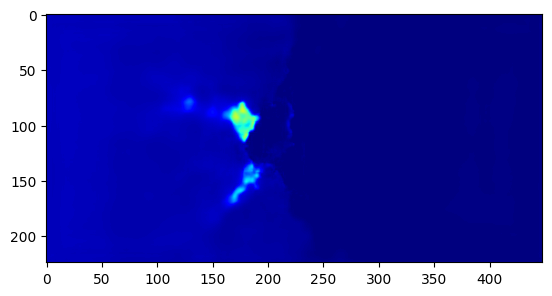

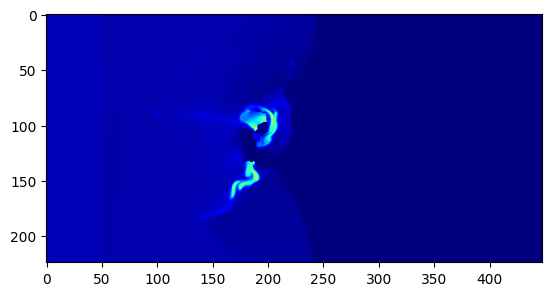

ts  4


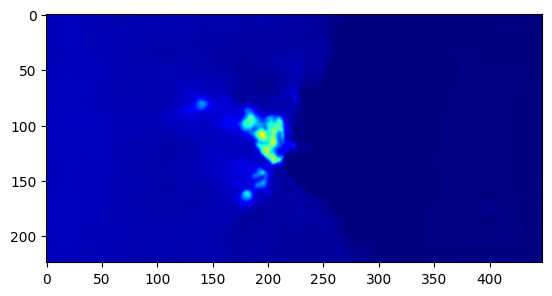

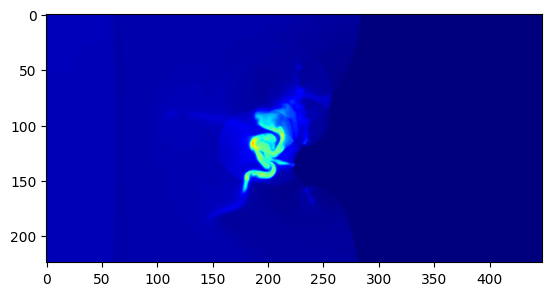

ts  5


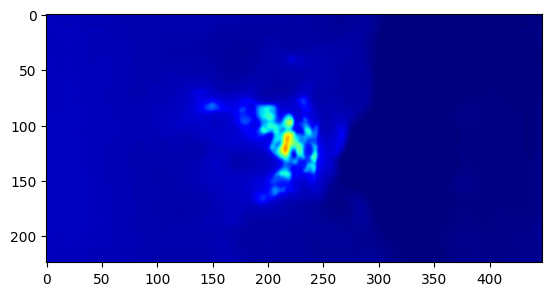

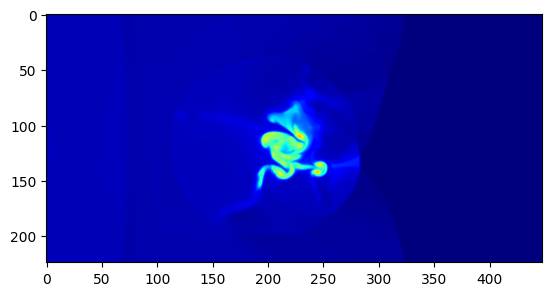

ts  6


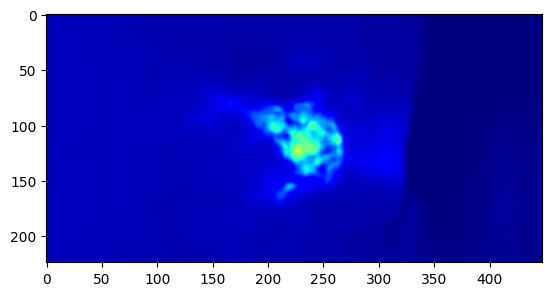

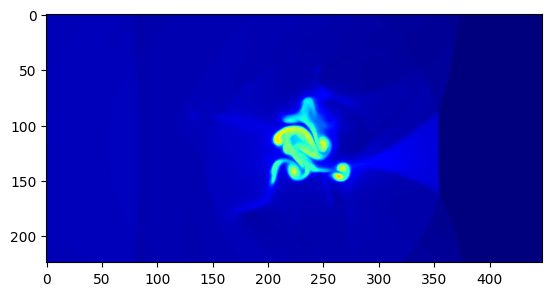

ts  7


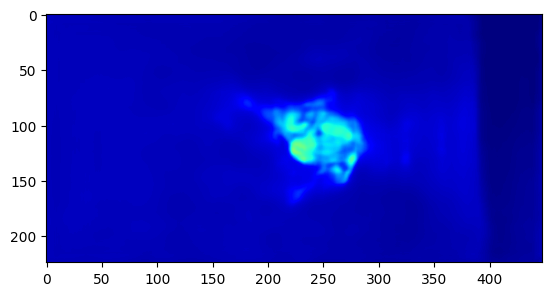

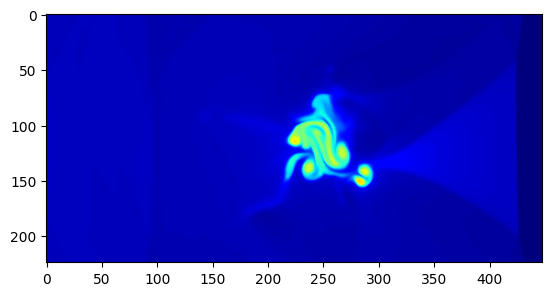

ts  8


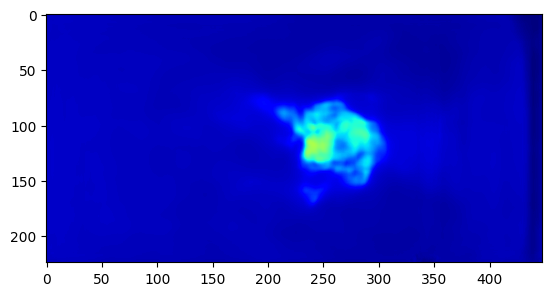

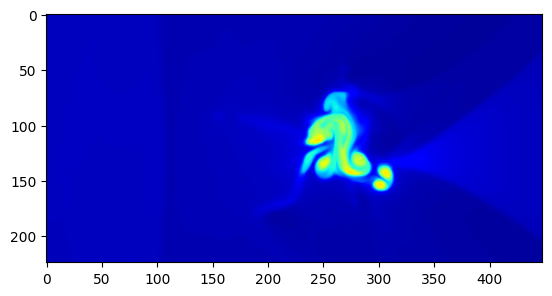

ts  9


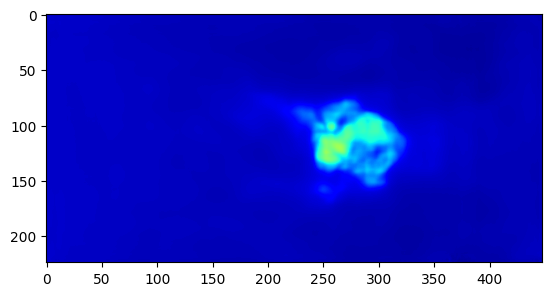

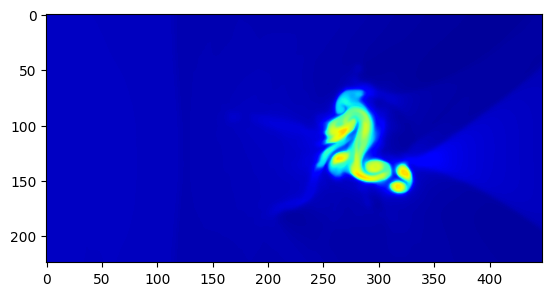

ts  10


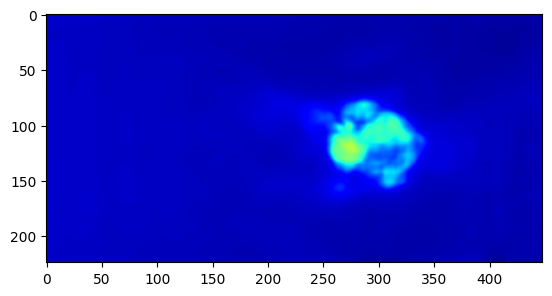

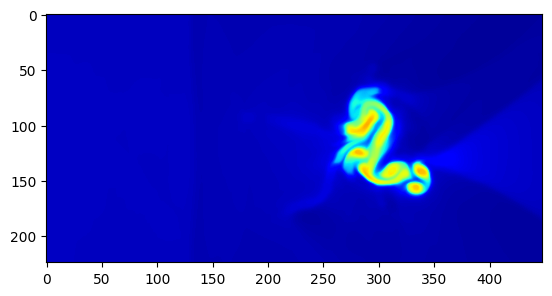

ts  11


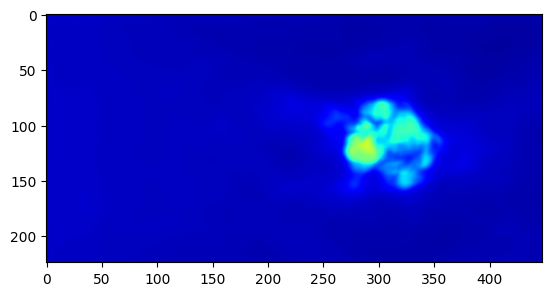

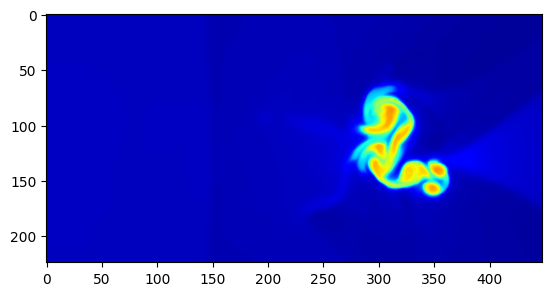

ts  12


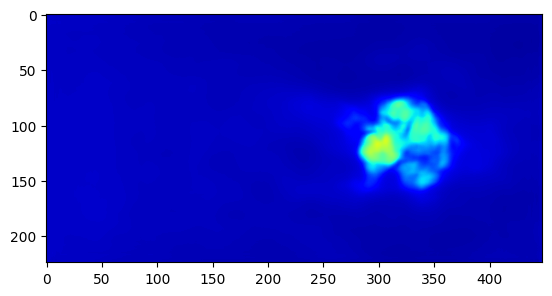

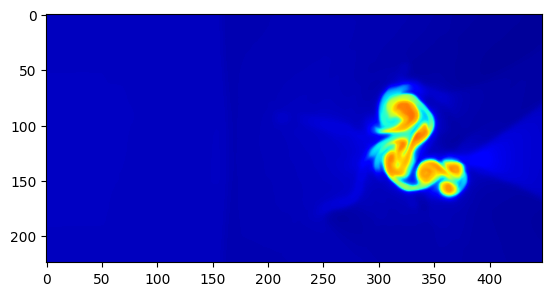

ts  13


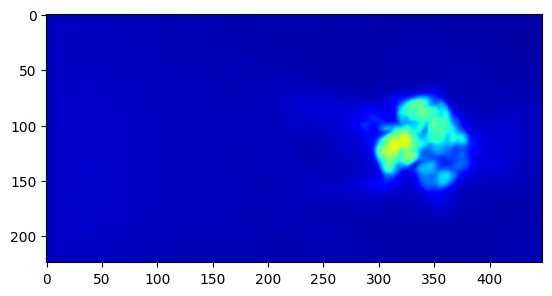

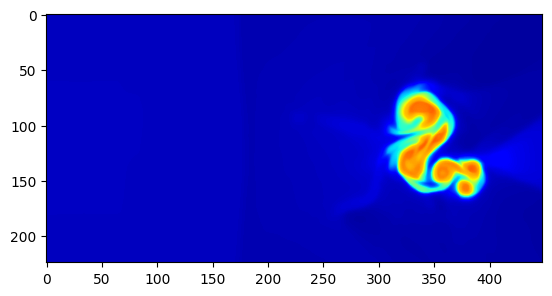

ts  14


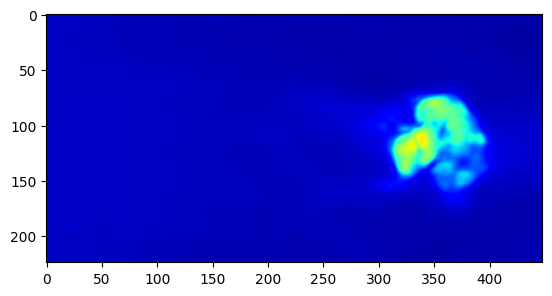

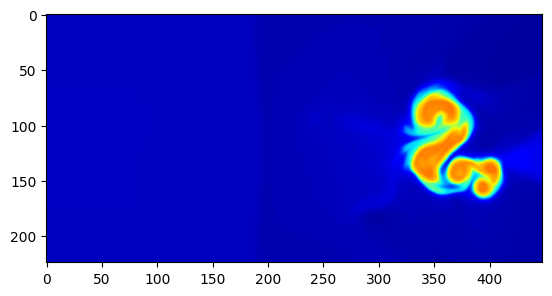

ts  15


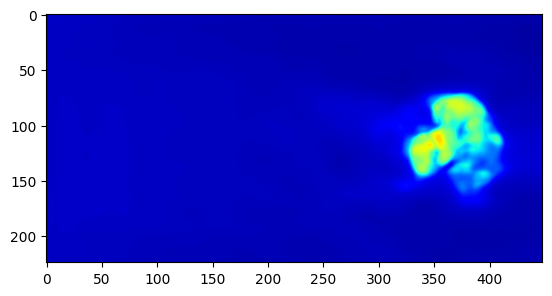

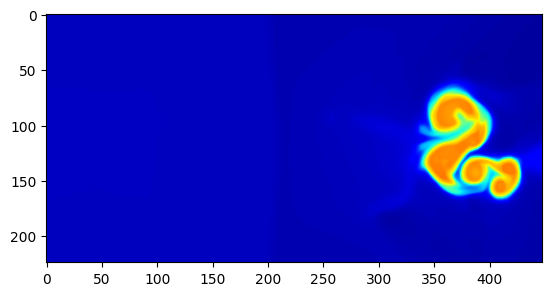

ts  16


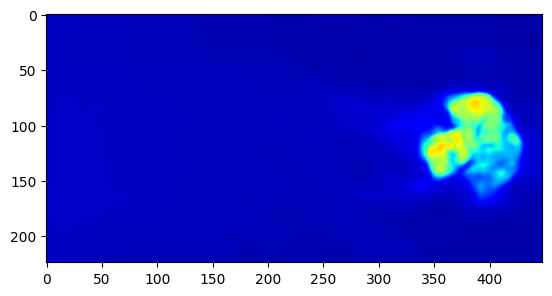

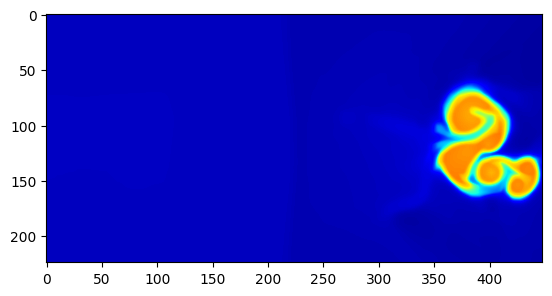

In [ ]:
data = total

data_in_test = []
data_out_test = []
data_test = []
for i in range(80,104):
    for j in range (1):
        data_in_test.append(latent_data[i,:,:,:,j+1:j+2])
        data_out_test.append(latent_data[i,:,:,:,j+2:j+19])
        data_test.append(data[i,:,:,j+2:j+19])

data_in_test = np.array(data_in_test)
data_out_test = np.array(data_out_test)
data_test = np.array(data_test)

idx = 0

zt_current = data_in_test[idx:idx+1,:,:,:]

output = []
gt = []
for i in range(17):
    zt_next = parc.latent_physics([zt_current])
    zt_current = zt_next

    recon = parc.mapping.decoder(zt_next)
    output.append(np.array(recon))

    gt.append(data_test[idx:idx+1,:,:,i])

output = np.array(output)
gt = np.array(gt)
    
channel = 0

for i in range(17):
    print('ts ',i)
    plt.imshow(np.squeeze(output[i,:,:,:,channel]),cmap = 'jet', vmin = -1, vmax = 1)
    plt.show()
    plt.imshow(np.squeeze(gt[i,:,:,:,channel]),cmap = 'jet', vmin = -1, vmax = 1)
    plt.show()